In [1]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

import model_utils
import plot_utils
import custom_transforms
from dataset import COCO_Person_Dataset
from nn_model import Net
from CONSTANTS import idx_to_keypoint_type
from custom_transforms import *
import torch.nn.functional as F
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import time

In [2]:
#17 keypoints
#'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 
#'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 
#'right_knee', 'left_ankle', 'right_ankle'

In [2]:
processed_files = {
    'img_id_to_annotations': 'img_id_to_annotations.npy',
    'img_id_to_image_info' : 'img_id_to_image_info.npy',
    'im_ids' : 'im_ids.npy'
}

In [3]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean, std = torch.tensor(mean), torch.tensor(std)

tfms = transforms.Compose([
    ResizeImgAndKeypoints(368),
    #ColorJitter(),
    RandomGrayscale(),
    #RandomFlipImgAndKeypoints(),
    #RandomRotateImgAndKeypoints()
])

tensor_tfms = transforms.Compose([
    ToTensor(),
    NormalizeImg(mean, std)
])

un = UnNormalizeImgBatch(mean, std)
p = transforms.ToPILImage()

In [4]:
bs = 8
ds = COCO_Person_Dataset('train2014/', processed_files, tfms, tensor_tfms)
dl = torch.utils.data.DataLoader(ds, bs, shuffle=True)

In [9]:
%%time 
for x,y,z,a,b in dl:
    break   

'get_heatmap_masks'  133.69 ms
'get_paf_masks'  92.71 ms
'get_heatmap_masks'  45.07 ms
'get_paf_masks'  67.32 ms
'get_heatmap_masks'  96.01 ms
'get_paf_masks'  70.08 ms
'get_heatmap_masks'  47.91 ms
'get_paf_masks'  52.40 ms
'get_heatmap_masks'  4.68 ms
'get_paf_masks'  38.27 ms
'get_heatmap_masks'  45.91 ms
'get_paf_masks'  44.44 ms
'get_heatmap_masks'  59.49 ms
'get_paf_masks'  51.20 ms
'get_heatmap_masks'  66.37 ms
'get_paf_masks'  50.65 ms
CPU times: user 7.95 s, sys: 203 ms, total: 8.15 s
Wall time: 1.38 s


In [7]:
#model.freeze_F()
#model.train_paf_stage(2)
#model.freeze_all_paf_stages()
#model.train_hm_stage(2)
#model.set_to_inference()

In [5]:
model = Net(in_training=True)
model.load_state_dict(torch.load('paf-stage4-training-model.ckpt', map_location='cpu'))
model.to(device)

Net(
  (F): F(
    (vgg): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

In [ ]:
model.train()
n_epochs = 1
lr = 0.0001
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = lr)

total_steps = 0
loss_running_avg_250_iter = 0


for e in range(n_epochs):
    for imgs, pafs, paf_inds, hms, hm_inds in dl:
        optimizer.zero_grad()
        
        imgs, pafs, paf_inds, hms, hm_inds = imgs.to(device), pafs.to(device), paf_inds.to(device), hms.to(device), hm_inds.to(device) 
        pred_pafs, pred_hms = model(imgs)
        loss = model_utils.paf_and_heatmap_loss(pred_pafs, pafs, paf_inds, pred_hms, hms, hm_inds)
        
        loss.backward()
        optimizer.step()
        
        total_steps +=1
        loss_running_avg_250_iter += loss.item()
        if(total_steps%250==0):
            torch.save(model.state_dict(),'paf-stage1-training-model.ckpt')
            print('saving model')
            print('current running avg loss:', loss_running_avg_250_iter/250)
            loss_running_avg_250_iter = 0
                                                       
        model_utils.print_training_loss_summary(loss.item(), total_steps, e+1, n_epochs, len(dl))

In [ ]:
torch.save(model.state_dict(),'stage1-trained.ckpt')

In [31]:
%%time
with torch.no_grad():
    model.eval()
    imgs, pafs, paf_inds, hms, hm_inds = iter(dl).next()
    pred_pafs_stages, pred_hms_stages = model(imgs.to(device))
    scaled_pafs = F.interpolate(pred_pafs_stages[0], 368, mode="bilinear", align_corners=True).to(device)

'get_heatmap_masks'  61.94 ms
'get_paf_masks'  58.24 ms
'__getitem__'  0.16 s
CPU times: user 2.49 s, sys: 104 ms, total: 2.59 s
Wall time: 1.17 s


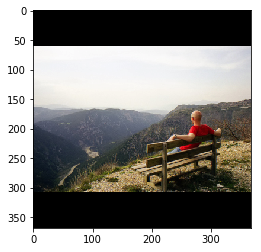

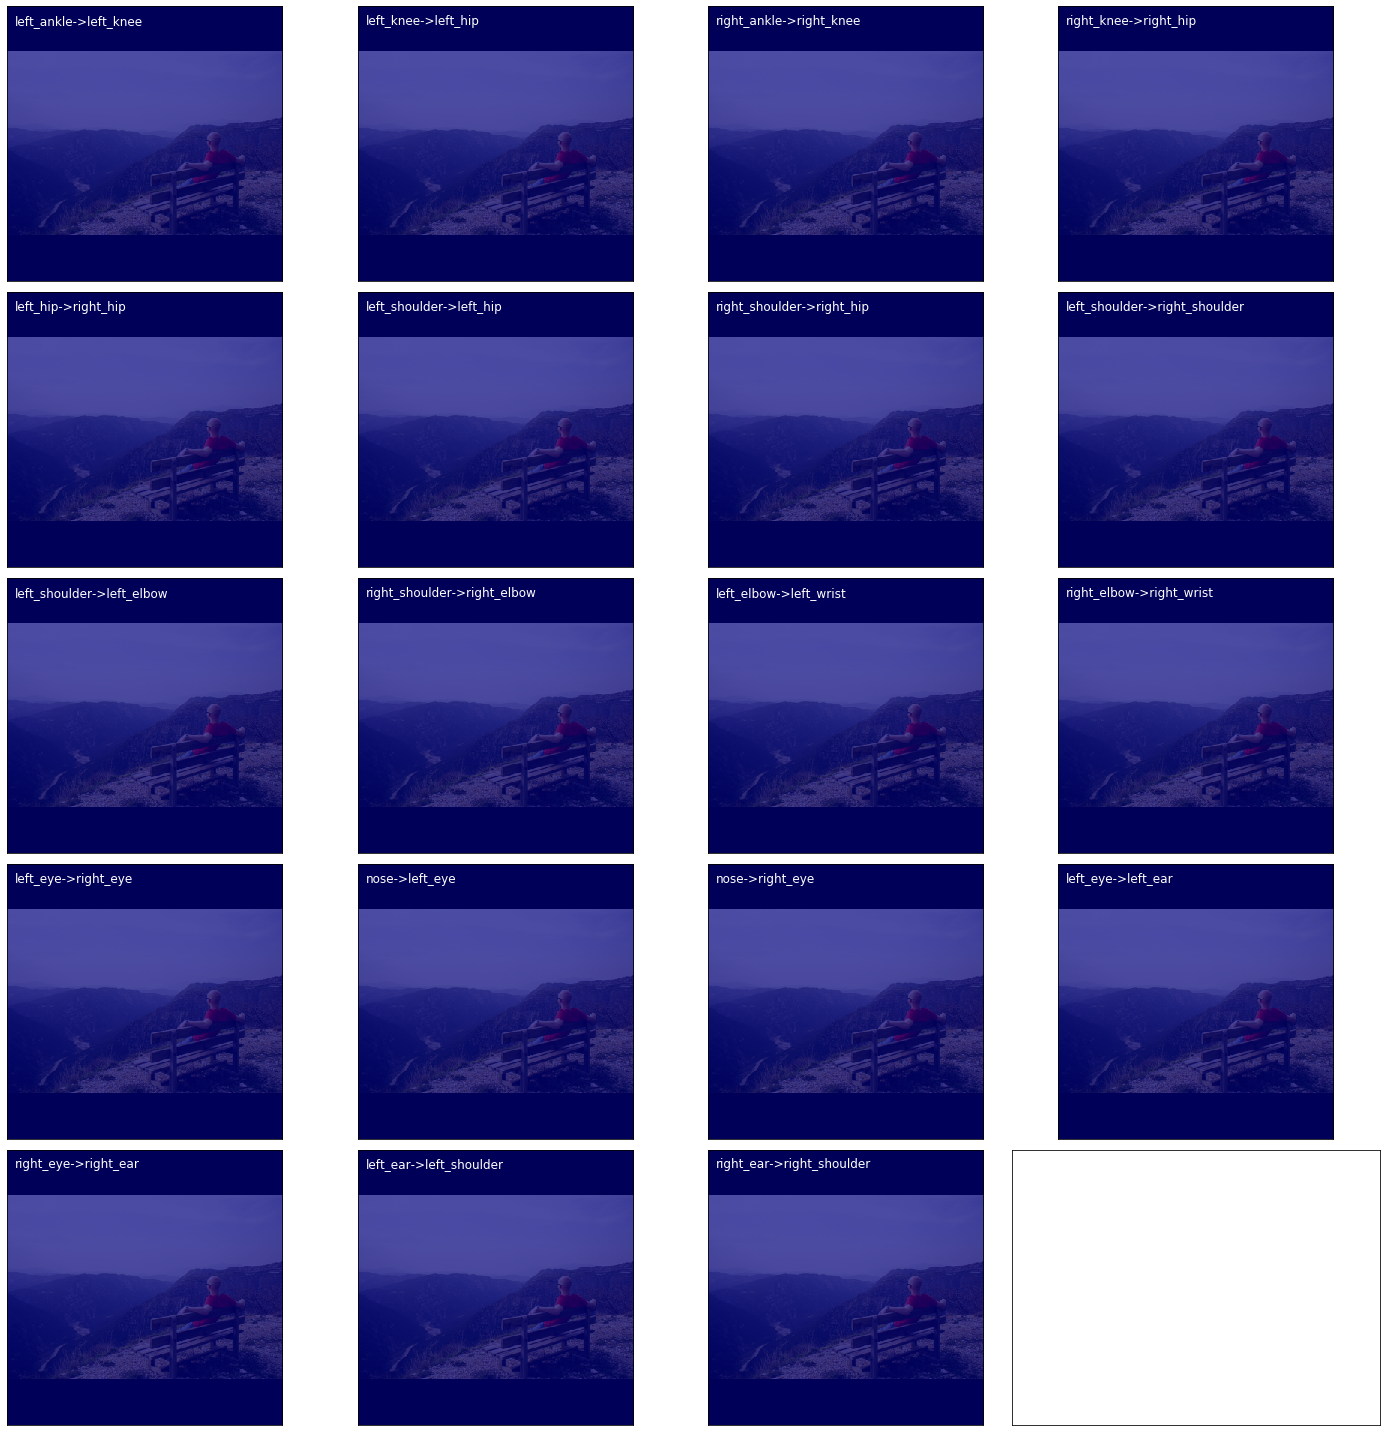

In [39]:
#i,pafs,paf_ind,hms,hms_ind = ds[1200], 6500
un_im = p(un(imgs)[0])
plt.imshow(un_im)
plot_utils.plot_pafs(un_im, (scaled_pafs[0]).numpy(), figsize=(20,20))
#plot_utils.plot_heatmaps(un_im, pred_hms.numpy(), figsize=(20,20))

In [6]:
%%time
i,pafs,paf_ind,hms,hms_ind = ds[1300]

'get_heatmap_masks'  18.43 ms
'get_paf_masks'  133.63 ms
CPU times: user 858 ms, sys: 54.5 ms, total: 913 ms
Wall time: 211 ms


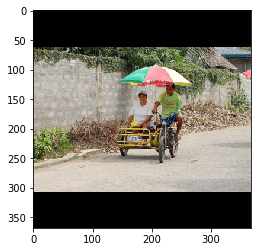

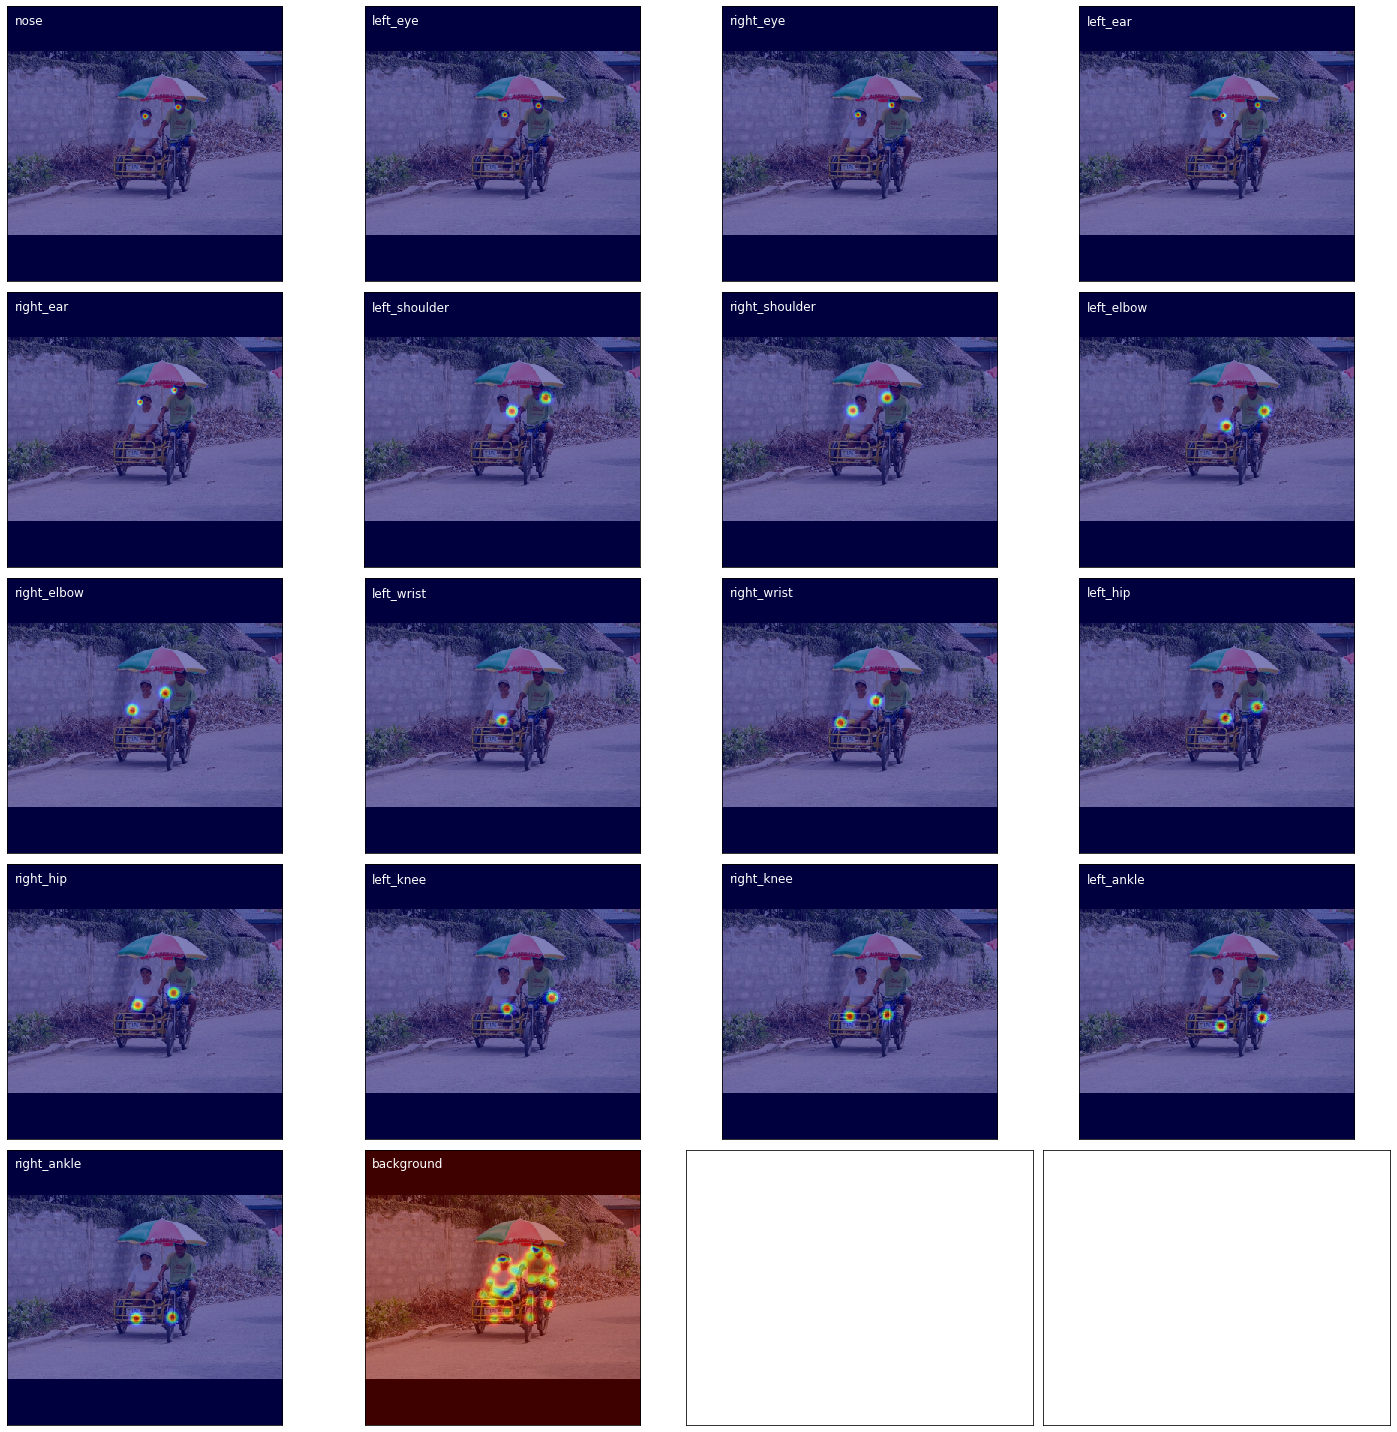

In [8]:
i,pafs,paf_ind,hms,hms_ind = ds[0]
un_im = p(un(i)[0])
plt.imshow(un_im)
#plot_utils.plot_pafs(un_im, pafs.numpy(), figsize=(20,20))
plot_utils.plot_heatmaps(un_im, hms.numpy(), figsize=(20,20))